In [2]:
import pandas as pd
import os
import random
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import collections
tqdm.pandas()
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

from scipy import stats
from sklearn.model_selection import KFold
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn import linear_model
from catboost import CatBoostClassifier

### 마지막 s 번째 행까지 분리

In [3]:
def custom_train_test_split(a,s):
    #test데이터셋은 각 유저의 마지막 interaction 추출
    test = a[a['userID'] != a['userID'].shift(-s)]
    train_ind = list(set(a.index)-set(test.index))
    train = a.loc[train_ind]
    return train, test

### 유저 별 test_id 별 인덱싱

In [4]:
def make_new_ind(a):
    new_a_ind = [1]
    a_testid = list(a['testId'])
    a_ass = list(a['assessmentItemID'])
    start_ind = 1
    ind_box = [a_ass[0]]
    for i in range(1,len(a)):
        now_ass = a_ass[i]
        if a_testid[i] != a_testid[i-1]:
            start_ind += 1
            ind_box = []
        else:   
            if now_ass in ind_box:
                start_ind += 1
                ind_box = []
        ind_box.append(now_ass)
        new_a_ind.append(start_ind)
    return new_a_ind

## 1. 데이터 로딩

In [5]:
df = pd.read_csv('train_data.csv', parse_dates=['Timestamp'])
df.sort_values(by=['userID','Timestamp'], inplace=True)

In [6]:
total_unique_testid = df.groupby('userID').apply(make_new_ind)

In [7]:
df_new_index = []
for i in total_unique_testid:
    for j in i:
        df_new_index.append(j)

In [8]:
testid_numbering = {}
for n,i in enumerate(df.testId.unique()):
    testid_numbering[i]=n

In [9]:
df['unique_testid'] = df_new_index

In [10]:
# timestamp 차이 행마다 넣기
df['time_diff'] = df.Timestamp.diff()

In [11]:
# 시험지의 첫번째 문제는 이전 시험지 마지막 문제와의 시간 차이 계산되는데, 이거를 none 값으로 주기 위함
first_index_list = list(df.drop_duplicates(['userID','unique_testid']).index)

In [12]:
df1 = df.loc[first_index_list]

In [13]:
no_first_index_list = list(set(df.index) - set(df1.index))
df2 = df.loc[no_first_index_list]

In [14]:
df1['time_diff'] = None

In [15]:
df = pd.concat([df1,df2])

In [16]:
df.sort_values(by=['userID','Timestamp'], inplace=True)

In [17]:
# test 내 문제들에 순서 매기기 위함
def user_test_time_sort(a):
    start = 1
    test_time_sort = [start]
    ut = list(a['unique_testid'])
    for i in range(1,len(a)):
        start += 1
        if ut[i] != ut[i-1]:
            start = 1
        test_time_sort.append(start)    
    return test_time_sort

In [18]:
all_test_time_sort = df.groupby('userID').apply(user_test_time_sort)

In [19]:
atts_list = []
for i in all_test_time_sort:
    for j in i:
        atts_list.append(j)

In [20]:
df['test_time_sort'] = atts_list

In [21]:
# 시간 차이 seconds로 변환 2 
df['seconds2'] = df.apply(lambda x : None if pd.isnull(x.time_diff) else x.time_diff.seconds , axis=1)

In [22]:
# 시간 차이 seconds로 변환 (780초 이상은 780으로)
df['seconds'] = df.apply(lambda x : None if pd.isnull(x.time_diff) else x.time_diff.seconds if x.time_diff < pd.Timedelta(seconds=780) else 780, axis=1)

In [23]:
# test 별 소요 시간 평균
seconds_mean = pd.DataFrame(df.groupby('testId').mean()['seconds'])
seconds_mean.columns = ["seconds_mean"]
df = pd.merge(df, seconds_mean, on=['testId'], how="left")

In [24]:
# assess 별 소요 시간 평균
assess_seconds_mean = pd.DataFrame(df.groupby('assessmentItemID').mean()['seconds'])
assess_seconds_mean.columns = ["assess_seconds_mean"]
df = pd.merge(df, assess_seconds_mean, on=['assessmentItemID'], how="left")

In [25]:
# tag 별 소요 시간 평균
tag_seconds_mean = pd.DataFrame(df.groupby('KnowledgeTag').mean()['seconds'])
tag_seconds_mean.columns = ["tag_seconds_mean"]
df = pd.merge(df, tag_seconds_mean, on=['KnowledgeTag'], how="left")

In [26]:
# 바로 직전 n번째 문제 맞았나 틀렸나 변수
def make_before_correct(a):
    return list(a['answerCode'].shift(1))

In [27]:
def make_before_correct2(a):
    return list(a['answerCode'].shift(2))

In [28]:
def make_before_correct3(a):
    return list(a['answerCode'].shift(3))

In [29]:
before_correct_list = df.groupby(['userID','unique_testid']).apply(make_before_correct)
before_correct_list2 = df.groupby(['userID','unique_testid']).apply(make_before_correct2)
before_correct_list3 = df.groupby(['userID','unique_testid']).apply(make_before_correct3)

In [30]:
before_correct = []
for i in before_correct_list:
    for j in i:
        before_correct.append(j)
before_correct2 = []
for i in before_correct_list2:
    for j in i:
        before_correct2.append(j)
before_correct3 = []
for i in before_correct_list3:
    for j in i:
        before_correct3.append(j)

In [31]:
df['before_correct'] = before_correct
df['before_correct2'] = before_correct2
df['before_correct3'] = before_correct3

In [32]:
# 최근 k 문제의 정답률 (자기 자신은 제외하기 위해서 빼줌)
def rolling_mean(a,k):
    return a['answerCode'].rolling(window=k).mean() - (a['answerCode'] / k)

In [33]:
# 최근 k개의 test들 중 마지막 문제들의 정답비율 
def user_last_ar(a,k):
    return sum(a.drop_duplicates('unique_testid',keep='last').answerCode[-k:])

In [34]:
rolling_20_list = df.groupby('userID').apply(rolling_mean,k=2)
rolling_20 = []
for i in rolling_20_list:
    rolling_20.append(i)
df['rolling_20'] = rolling_20

rolling_10_list = df.groupby('userID').apply(rolling_mean,k=10)
rolling_10 = []
for i in rolling_10_list:
    rolling_10.append(i)
df['rolling_10'] = rolling_10

rolling_5_list = df.groupby('userID').apply(rolling_mean,k=3)
rolling_5 = []
for i in rolling_5_list:
    rolling_5.append(i)
df['rolling_5'] = rolling_5

rolling_15_list = df.groupby('userID').apply(rolling_mean,k=4)
rolling_15 = []
for i in rolling_15_list:
    rolling_15.append(i)
df['rolling_15'] = rolling_15

### test 데이터셋도 train에 포함시킴

In [35]:
test_df_origin = pd.read_csv('test_data.csv', parse_dates=['Timestamp'])
test_df_origin.sort_values(by=['userID','Timestamp'], inplace=True)

In [36]:
total_unique_testid = test_df_origin.groupby('userID').apply(make_new_ind)
df_new_index = []
for i in total_unique_testid:
    for j in i:
        df_new_index.append(j)

In [37]:
test_df_origin['unique_testid'] = df_new_index

In [38]:
test_df_origin['time_diff'] = test_df_origin.Timestamp.diff()
first_index_list = list(test_df_origin.drop_duplicates(['userID','unique_testid']).index)
df1 = test_df_origin.loc[first_index_list]
no_first_index_list = list(set(test_df_origin.index) - set(df1.index))
df2 = test_df_origin.loc[no_first_index_list]
df1['time_diff'] = None
test_df_origin = pd.concat([df1,df2])
test_df_origin.sort_values(by=['userID','Timestamp'], inplace=True)
test_df_origin['seconds2'] = test_df_origin.apply(lambda x : None if pd.isnull(x.time_diff) else x.time_diff.seconds, axis=1)
test_df_origin['seconds'] = test_df_origin.apply(lambda x : None if pd.isnull(x.time_diff) else x.time_diff.seconds if x.time_diff < pd.Timedelta(seconds=780) else 780, axis=1)

In [39]:
# test 별 소요 시간 평균
seconds_mean = pd.DataFrame(test_df_origin.groupby('testId').mean()['seconds'])
seconds_mean.columns = ["seconds_mean"]
test_df_origin = pd.merge(test_df_origin, seconds_mean, on=['testId'], how="left")

In [40]:
# assess 별 소요 시간 평균
assess_seconds_mean = pd.DataFrame(test_df_origin.groupby('assessmentItemID').mean()['seconds'])
assess_seconds_mean.columns = ["assess_seconds_mean"]
test_df_origin = pd.merge(test_df_origin, assess_seconds_mean, on=['assessmentItemID'], how="left")

In [41]:
# tag 별 소요 시간 평균
tag_seconds_mean = pd.DataFrame(test_df_origin.groupby('KnowledgeTag').mean()['seconds'])
tag_seconds_mean.columns = ["assess_seconds_mean"]
test_df_origin = pd.merge(test_df_origin, tag_seconds_mean, on=['KnowledgeTag'], how="left")

In [42]:
all_test_time_sort = test_df_origin.groupby('userID').apply(user_test_time_sort)

atts_list = []
for i in all_test_time_sort:
    for j in i:
        atts_list.append(j)
        
test_df_origin['test_time_sort'] = atts_list

In [43]:
before_correct_list = test_df_origin.groupby(['userID','unique_testid']).apply(make_before_correct)
before_correct_list2 = test_df_origin.groupby(['userID','unique_testid']).apply(make_before_correct2)
before_correct_list3 = test_df_origin.groupby(['userID','unique_testid']).apply(make_before_correct3)

before_correct = []
for i in before_correct_list:
    for j in i:
        before_correct.append(j)
before_correct2 = []
for i in before_correct_list2:
    for j in i:
        before_correct2.append(j)
before_correct3 = []
for i in before_correct_list3:
    for j in i:
        before_correct3.append(j)

test_df_origin['before_correct'] = before_correct
test_df_origin['before_correct2'] = before_correct2
test_df_origin['before_correct3'] = before_correct3

In [44]:
rolling_15_list = test_df_origin.groupby('userID').apply(rolling_mean,k=2)
rolling_15 = []
for i in rolling_15_list:
    rolling_15.append(i)
test_df_origin['rolling_15'] = rolling_15

rolling_20_list = test_df_origin.groupby('userID').apply(rolling_mean,k=3)
rolling_20 = []
for i in rolling_20_list:
    rolling_20.append(i)
test_df_origin['rolling_20'] = rolling_20

rolling_10_list = test_df_origin.groupby('userID').apply(rolling_mean,k=10)
rolling_10 = []
for i in rolling_10_list:
    rolling_10.append(i)
test_df_origin['rolling_10'] = rolling_10

rolling_5_list = test_df_origin.groupby('userID').apply(rolling_mean,k=4)
rolling_5 = []
for i in rolling_5_list:
    rolling_5.append(i)
test_df_origin['rolling_5'] = rolling_5

### test로 쓸 데이터랑 제출용 데이터는 분리시킴

In [45]:
test_train, test_test_df = custom_train_test_split(test_df_origin,2)

In [46]:
# train 용 답의 index 추출
test_test_index = list(test_test_df.index)

In [47]:
# train,test 합쳐서 훈련 
new_df = pd.concat([test_df_origin,df])

In [48]:
# test 내 문제 수
def len_ass(a):
    return a.assessmentItemID.nunique()

## 2. Feature Engineering

In [49]:
def feature_engineering(df,tti):
    drop_tti = list(set(df.index)-set(tti))
    df2 = df.iloc[drop_tti]
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']
    df['sort_assess'] = df.apply(lambda x : int(x['assessmentItemID'][-2:]),axis=1)
    df['testid_numbering'] = df.apply(lambda x : testid_numbering[x.testId],axis=1)
    # df['month'] = df.apply(lambda x: 1 if int(x.Timestamp.month) <11 else 0,axis=1)
    # df['hour'] = df.apply(lambda x: int(x.Timestamp.hour),axis=1)
    len_ass_df = pd.DataFrame(df.groupby('testId').apply(len_ass))
    len_ass_df.columns = ["len_ass"]
    df = pd.merge(df, len_ass_df, on=['testId'], how="left")
    # last_same_df = df.drop_duplicates(['userID','testId'],keep='last')
    # last_same_df['last_same1'] = last_same_df.apply(lambda x : 1 if x.sort_assess == x.len_ass else 0 ,axis=1)
    # last_same_df['last_same2'] = last_same_df.apply(lambda x : 1 if x.test_time_sort == x.len_ass else 0 ,axis=1)
    # df = pd.merge(df, last_same_df[['userID','testId','last_same1']], on=['userID','testId'], how="left")
    # df = pd.merge(df, last_same_df[['userID','testId','last_same2']], on=['userID','testId'], how="left")
    

    
    
    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df2.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    correct_k = df2.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']
    correct_a = df2.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum'])
    correct_a.columns = ["ass_mean", 'ass_sum']
    # 유저별로도 정답률 평균 등 구함
    correct_u = df2.groupby(['userID'])['answerCode'].agg(['mean', 'sum'])
    correct_u.columns = ["u_mean", 'u_sum']
    
    last_correct = pd.DataFrame(df2.groupby('userID').apply(user_last_ar,k=5))
    last_correct.columns = ["last_correct"]
    
    
    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    df = pd.merge(df, correct_a, on=['assessmentItemID'], how="left")
    df = pd.merge(df, correct_u, on=['userID'], how="left")
    
    df = pd.merge(df, last_correct, on=['userID'], how="left")
    
    return df

In [50]:
new_df = feature_engineering(new_df,test_test_index)

In [51]:
tests_answer_ratio = new_df.drop_duplicates('testId')[['testId','test_mean']]

In [52]:
# 유저 별 시험 본 test들의 평균 정답률
def user_test_mean(a):
    return np.mean(tests_answer_ratio[tests_answer_ratio.testId.isin(a.testId.unique())].test_mean)

In [53]:
user_test_mean_df = pd.DataFrame(new_df.groupby('userID').apply(user_test_mean))
user_test_mean_df.columns = ["user_test_mean"]

In [54]:
new_df = pd.merge(new_df, user_test_mean_df, on=['userID'], how="left")

In [55]:
new_df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,unique_testid,time_diff,seconds2,seconds,...,test_mean,test_sum,tag_mean,tag_sum,ass_mean,ass_sum,u_mean,u_sum,last_correct,user_test_mean
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,1,None,NaN,NaN,...,0.575139,930,0.648995,1065,0.692641,160,0.693424,717.0,1.0,0.685499
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,1,0 days 00:00:26,26.0,26.0,...,0.575139,930,0.648995,1065,0.649351,150,0.693424,717.0,1.0,0.685499
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,1,0 days 00:01:34,94.0,94.0,...,0.575139,930,0.671922,1577,0.571429,132,0.693424,717.0,1.0,0.685499
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,1,0 days 00:00:05,5.0,5.0,...,0.575139,930,0.671922,1577,0.653680,151,0.693424,717.0,1.0,0.685499
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,1,0 days 00:00:07,7.0,7.0,...,0.575139,930,0.580471,2467,0.320346,74,0.693424,717.0,1.0,0.685499


## 3. Train/Test 데이터 셋 분리

In [56]:
# test 인덱스
test = new_df.iloc[test_test_index]

In [57]:
# train 인덱스
train_index = set(new_df.index) - set(test.index)

In [58]:
# 최종 제출용 데이터셋 분리
test, test_df = custom_train_test_split(test,1)

In [59]:
test.sort_values(by=['userID','Timestamp'], inplace=True)

In [60]:
test_df.sort_values(by=['userID','Timestamp'], inplace=True)

In [61]:
train = new_df.loc[train_index]

<ipython-input-61-a54b5808724c>:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train = new_df.loc[train_index]


In [62]:
# # 모든 데이터셋 포함해서 다시 학습하기 위한 데이터셋
again_total_df = pd.concat([train,test])

### 최종 사용할 Feature 선정

In [63]:
FEATS = [  'seconds','user_correct_answer','user_total_answer','before_correct', 'before_correct2','rolling_10','seconds_mean',
         'user_acc',  'tag_mean','sort_assess','test_mean','test_sum', 'ass_mean','u_mean','u_sum']

In [64]:
# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

### scaler 시도 - 오히려 안 좋아져서 사용 안함

In [1150]:
# scaler = StandardScaler()
# # scaler.fit(train[FEATS])

In [1151]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# scaler.fit(train[FEATS])

In [1152]:
# from sklearn.preprocessing import RobustScaler

# scaler = RobustScaler()
# scaler.fit(train[FEATS])

In [1153]:
# from sklearn.preprocessing import MaxAbsScaler
# scaler = MaxAbsScaler()
# scaler.fit(train[FEATS])

In [1154]:
# tf1 = train[FEATS]
# tf2 = test[FEATS]
# scaler.fit(tf1)
# tf1.loc[:,FEATS] = scaler.transform(tf1)
# tf2.loc[:,FEATS] = scaler.transform(tf2)

# lgb_train = lgb.Dataset(tf1, y_train)
# lgb_test = lgb.Dataset(tf2, y_test)

In [1155]:
# train['seconds3'] = train.apply(lambda x : None if pd.isnull(x.seconds2) else x.seconds2 if x.seconds2 < 1080 else 1080, axis=1)

In [1156]:
# test['seconds3'] = test.apply(lambda x : None if pd.isnull(x.seconds2) else x.seconds2 if x.seconds2 < 1080 else 1080, axis=1)

## 4. 훈련 및 검증 - k fold 시도

In [1239]:
folds = KFold(n_splits = 2, shuffle = True, random_state = 42)
oof_preds = np.zeros(train.shape[0])

In [66]:
# lgbm 하이퍼 파라미터
params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'binary', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5}

In [1241]:
tF = train[FEATS]
testF = test[FEATS]
sub_preds_lgm = np.zeros(test.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(tF)) : 
    trn_x, trn_y = tF.iloc[trn_idx], y_train.iloc[trn_idx] 
    val_x, val_y = tF.iloc[val_idx], y_train.iloc[val_idx] 
    train_T = lgb.Dataset(trn_x, label=trn_y) 
    val_T = lgb.Dataset(val_x, label=val_y) 
    model = lgb.train(params, train_T, 10000, val_T, verbose_eval=1000, early_stopping_rounds=100) 
    sub_preds_lgm += model.predict(testF) / folds.n_splits 
    # oof_preds[val_idx] = model.predict(val_x) 

acc = accuracy_score(y_test, np.where(sub_preds_lgm >= 0.5, 1, 0))
auc = roc_auc_score(y_test, sub_preds_lgm)

print(f'VALID AUC : {auc} ACC : {acc}\n')

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 826251, number of negative: 436355
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2835
[LightGBM] [Info] Number of data points in the train set: 1262606, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654401 -> initscore=0.638442
[LightGBM] [Info] Start training from score 0.638442
Training until validation scores don't improve for 100 rounds
[1000]	valid_0's binary_logloss: 0.450226
[2000]	valid_0's binary_logloss: 0.44898
[3000]	valid_0's binary_logloss: 0.448314
[4000]	valid_0's binary_logloss: 0.447961
[5000]	valid_0's binary_logloss: 0.447705
[6000]	valid_0's binary_logloss: 0.447527
[7000]	valid_0's binary_logloss: 0.447419
Early stopping, best iteration is:
[7830]	valid_0's binary_logloss: 0.447347
[Ligh

## k fold 사용 안 했을 때 - 현재 가장 높은 점수

In [1234]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

In [1235]:
model = lgb.train(params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=200,
    num_boost_round=10000,
    early_stopping_rounds=100
)

preds = model.predict(test[FEATS])

### scaler 할 떄
# preds = model.predict(tf2)

acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1653175, number of negative: 872037
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2834
[LightGBM] [Info] Number of data points in the train set: 2525212, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654668 -> initscore=0.639621
[LightGBM] [Info] Start training from score 0.639621
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.466153	valid_1's binary_logloss: 0.507327
[400]	training's binary_logloss: 0.452574	valid_1's binary_logloss: 0.49333
[600]	training's binary_logloss: 0.448988	valid_1's binary_logloss: 0.489183
[800]	training's binary_logloss: 0.446803	valid_1's binary_logloss: 0.486443
[1000]	training's binary_logloss: 0.445181	valid_1's binary_logloss

## catboost 사용

In [1227]:
cb_model = CatBoostRegressor(iterations=1500, learning_rate=0.1, depth=4, l2_leaf_reg=20, bootstrap_type='Bernoulli', subsample=0.6, metric_period=50, od_type='Iter', od_wait=45, random_seed=42, allow_writing_files=False)
# cb_model = CatBoostClassifier(iterations=1500,learning_rate=0.1, depth=4, l2_leaf_reg=20, bootstrap_type='Bernoulli', subsample=0.6, metric_period=50, od_type='Iter', od_wait=45, random_seed=42, allow_writing_files=False)

In [1]:
cb_model.fit( 
    train[FEATS],y_train,
    eval_set=(test[FEATS], y_test),
    verbose=200,
    use_best_model=True,
)

preds = cb_model.predict(test[FEATS])

### scaler 할 떄
# preds = model.predict(tf2)

acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

## feature importance - 높거나 낮음이 절대적인 영향 주지는 않음

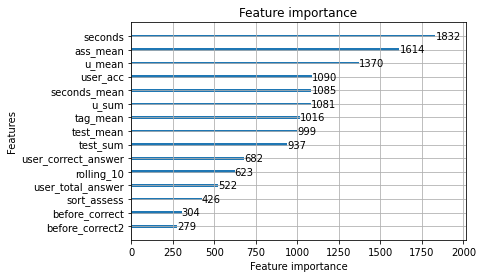

In [ ]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model)

## 5. Inference

In [586]:
# ## scaler 할 때
# scaler_tf = test_df[FEATS]
# scaler_tf.loc[:,FEATS] = scaler.transform(scaler_tf)
# # MAKE PREDICTION
# total_preds = model.predict(scaler_tf)

<ipython-input-586-c8c6b2d17e29>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaler_tf.loc[:,FEATS] = scaler.transform(scaler_tf)


In [1081]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [1082]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "submission_name넣기.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/tag_seconds_mean.csv
